# Final: Practical

### This practical contains 6 problems, labeled 'Problem 1', 'Problem 2', etc.  Please read the instructions carefully.  I estimated 10 minutes work per problem.   Only edit cells that you are directed to edit.

### Submission: Please submit your .ipynb file only.  The file you submit must have output that demonstrates your answers.  I recommend restarting and then running all cells before you submit.

### Grading: Each problem is worth a maximum of 10 points.  Any points above 50 will be treated as extra credit points.

In [1]:
%matplotlib inline

## Part 1.  Machine learning in Python

### In this section we'll use the "census summary" data set, which contains census information plus a label showing whether the income associated with the individual is > $50,000/year.  (The data is from 1994.)

In [2]:
# ADD imports to this cell as needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns   
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

### Read the data

In [3]:
input_file = "https://raw.githubusercontent.com/grbruns/cst495/master/1994-census-summary.csv"
dat = pd.read_csv(input_file)

### Basic preprocessing

In [4]:
# remove some columns
dat.drop(['usid', 'fnlwgt', 'education', 'native_country'], axis=1, inplace=True)

# remove rows containing NaN
dat.dropna(inplace=True)

### Exploration and visualization

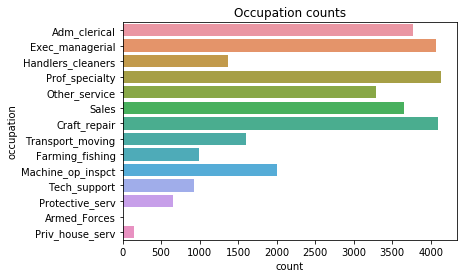

In [5]:
# tabulate the number of values in each category of the "occupation" column, and plot
# as a barplot
sns.countplot(y="occupation", orient="v", data=dat)
plt.title('Occupation counts');

### Final preprocessing.   Steps here include creation of dummy variables for categorical variables, creation of new target variable, creation of numeric numpy matrix, and scaling of the data.

In [6]:
dat = pd.get_dummies(dat, columns=['workclass', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'label'], drop_first=True)

# derive numpy array y from label column, then remove the column
y = dat['label_>50K'].values
dat.drop(['label_>50K'], axis=1, inplace=True)

# create a numpy matrix X from dat1
X = dat.values.astype(float)  # converting to float avoids StandardScalar warnings

# scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Problem 1

Create a new matrix X_reduced, which will have only 5 features, and then create a training and test set from X_reduced and y.  You can get the 5 features using feature selection, or by using dimensionality reduction.  You can choose your train/test ratio.

I will be looking at the accuracy of your classification result, so think about how to create/select your 5 features.

In [7]:
pca = PCA(n_components = 5)
X_reduced = pca.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_reduced,
y, test_size=0.25)

### Problem 2a

Your job here is to create a classifier, train it, and then test your accuracy with your test set.  You can choose your predictor, but only use NumPy, Pandas, and Scikit-Learn, and use only a type of predictor we have seen in class.

You are also required to use grid search to find good hyperparameter values for your classifier.  Because you are working under time contraints, it will be enough to check 6 or 8 combinations of hyperparameters.

Print your accuracy on the test set.  You should be able to achieve 83% accuracy or more.

In [8]:
rnd_clf = RandomForestClassifier(n_estimators = 60, n_jobs = -1)
rnd_clf_fitted = rnd_clf.fit(X_train, y_train)
RFC_score = rnd_clf.score(X_test, y_test)

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)

svm_clf = SVC(gamma="scale")
g_clf = GradientBoostingClassifier(n_estimators = 5, learning_rate = 1.0)
voting_clf = VotingClassifier(
estimators=[('clf', clf), ('rf', rnd_clf), ('svc', svm_clf), ('gboost', g_clf)],
voting='hard')
voting_clf.fit(X_train, y_train)

for clf1 in (clf, rnd_clf, svm_clf, g_clf, voting_clf):
    clf1.fit(X_train, y_train)
    y_pred = clf1.predict(X_test)
    print(clf1.__class__.__name__, accuracy_score(y_test, y_pred))
    
parameters = {'C': [10], 'gamma': [0.1], 'kernel': ['rbf']}
clf2 = GridSearchCV(svm_clf, parameters, cv=6)
clf2.fit(X_train, y_train)
y_pred = clf2.predict(X_test)
print(clf2.__class__.__name__, accuracy_score(y_test, y_pred))

DecisionTreeClassifier 0.7861979166666667
RandomForestClassifier 0.8244791666666667
SVC 0.8305989583333333
GradientBoostingClassifier 0.8235677083333334
VotingClassifier 0.8287760416666666
GridSearchCV 0.8313802083333334


### Problem 2b

In the markdown cell below, please write two or three sentences on why you chose the approach that you did in Problem 2a.

For feature selection, I used PCA to reduce the number of features to 5, as this is simple and tends to be the best method of selecting features.

For estimators, I tried using a voting classifier which used a random forest, an SVM, and and decision trees as its inputs. This resulted in accuracy that was very close to 83% across multiple attempts, but could not have it break that 83% barrier. Since I was close to the 83% accuracy mark, I tried to use grid search tuning the hyperparameters of the Support Vector Machine, and this improved my accuracy above the 83% mark.

Since I got a result very close to 83% accuracy, I then tried tuning the hyperparameters of gradient boosting.  The problem is that grid search took a long time, so I wasn't able to try many different parameter values.  

## Part 2.  Deep Learning with TensorFlow

### MNIST classification with a CNN, shared header code.  This must be run before working on any of the CNN cells.

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

# adjust logging verbosity level
old_verbosity = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)

# load data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

# reset verbosity level
tf.logging.set_verbosity(old_verbosity)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


### MNIST classification with a CNN, base code

The code below is a slightly modified version of Geron's MNIST classifier.  It uses two convolutional layers, a pooling layer, and two dense layers.  You should run the code to make sure it works for you. 

In [ ]:
#
# graph building phase
#

height = 28
width = 28
channels = 1
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = conv2_fmaps

n_fc1 = 64
n_outputs = 10

tf.reset_default_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 7 * 7])

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

#
# graph execution phase
#

n_epochs = 5
batch_size = 10
test_batch_size = 20

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        # train
        for iteration in range(mnist.train.num_examples // batch_size):
            X_train, y_train = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_train, y: y_train})
        # loss and training accuracy
        loss_val, acc_train = sess.run([loss, accuracy], feed_dict={X: X_train, y: y_train})
        # test accuracy
        X_test, y_test = mnist.test.next_batch(test_batch_size)
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        
        print(epoch, "loss:", loss_val, ", train accuracy:", acc_train, ", test accuracy:", acc_test)
        # save_path = saver.save(sess, "./my_mnist_model")

### Problem 3

The code below is a copy of the base code.  Your job is to remove the second convolutional layer, and then make the smallest changes needed to get the CNN working again.  Do not add any new layers.

In [ ]:
#
# graph building phase
#

height = 28
width = 28
channels = 1
n_inputs = height * width

conv1_fmaps = 64
conv1_ksize = 3
conv1_stride = 2
conv1_pad = "SAME"

#conv2_fmaps = 64
#conv2_ksize = 3
#conv2_stride = 2
#conv2_pad = "SAME"

#pool3_fmaps = conv2_fmaps
pool3_fmaps = conv1_fmaps

n_fc1 = 64
n_outputs = 10

tf.reset_default_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
#conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
#                         strides=conv2_stride, padding=conv2_pad,
#                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 7 * 7])

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

#
# graph execution phase
#

n_epochs = 5
batch_size = 10
test_batch_size = 20

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        # train
        for iteration in range(mnist.train.num_examples // batch_size):
            X_train, y_train = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_train, y: y_train})
        # loss and training accuracy
        loss_val, acc_train = sess.run([loss, accuracy], feed_dict={X: X_train, y: y_train})
        # test accuracy
        X_test, y_test = mnist.test.next_batch(test_batch_size)
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        
        print(epoch, "loss:", loss_val, ", train accuracy:", acc_train, ", test accuracy:", acc_test)
        # save_path = saver.save(sess, "./my_mnist_model")

### Problem 4

The code below is like the base code, except that two new nodes have been introduced: 'probs' and 'y_hot'.  Your job is to change the right hand side of the line 'xentropy = ...', and to replace the TensorFlow function on the right with a different TensorFlow function.  The arguments provided to the new function should include either 'prob' or 'y_hot' or both.

In [ ]:
#
# graph building phase
#

height = 28
width = 28
channels = 1
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = conv2_fmaps

n_fc1 = 64
n_outputs = 10

tf.reset_default_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    y_hot = tf.one_hot(y, n_outputs)

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 7 * 7])

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    probs = tf.nn.softmax(logits, name="probs")

with tf.name_scope("train"):
    xentropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y_hot) 
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

#
# graph execution phase
#

n_epochs = 5
batch_size = 50
test_batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        # train
        for iteration in range(mnist.train.num_examples // batch_size):
            X_train, y_train = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_train, y: y_train})
        # loss and training accuracy
        loss_val, acc_train = sess.run([loss, accuracy], feed_dict={X: X_train, y: y_train})
        # test accuracy
        X_test, y_test = mnist.test.next_batch(test_batch_size)
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        
        print(epoch, "loss:", loss_val, ", train accuracy:", acc_train, ", test accuracy:", acc_test)
        # save_path = saver.save(sess, "./my_mnist_model")

### Character-level text modeling with an RNN, shared header code.  This code must be run before working on any of the RNN cells.

 If you don't have the Alice.txt file handy, you can get from our class GoogleDrive: https://drive.google.com/open?id=1phSka_OrfrKDajE-0Vyk_AyT4KFb-YdC 

In [1]:
import numpy as np
import tensorflow as tf

# replace the file path here with your own
data = (open("C:/Users/Glenn/Google Drive/CSUMB/Spring18/DS/homework/week6/alice.txt").read())

# create mapping from characters to numbers and back
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
char_to_ix = { ch:i for i,ch in enumerate(chars) }   # dict comprehension
ix_to_char = { i:ch for i,ch in enumerate(chars) }

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Glenn/Google Drive/CSUMB/Spring18/DS/homework/week6/alice.txt'

### Character-level text modeling with an RNN, base code

The code below is a simple TensorFlow version of Karpathy's character-level text model.  Make sure you can run the code.

In [ ]:
# create training sequences, and corresponding labels
X = []
y = []
seq_length = 50
for i in range(0, len(data)-seq_length-1, 1):
    X.append([char_to_ix[ch] for ch in data[i:i+seq_length]])
    y.append([char_to_ix[ch] for ch in data[i+1:i+seq_length+1]])

# reshape the data; in X_modified, each row is an encoded 
# sequence of characters
X_modified = np.reshape(X, (len(X), seq_length))
y_modified = np.reshape(y, (len(y), seq_length))

#
# graph construction
#

n_steps = seq_length
n_inputs = vocab_size
n_outputs = vocab_size
n_neurons = 100

learning_rate = 0.001

tf.reset_default_graph()

X = tf.placeholder(tf.int32, [None, n_steps])
X_hot = tf.one_hot(X, n_inputs)
y = tf.placeholder(tf.int32, [None, n_steps])

# alternative: GPU-enabled GRU cell
#        tf.contrib.cudnn_rnn.CudnnCompatibleGRUCell(num_units=n_neurons),

basic_cell = tf.contrib.rnn.OutputProjectionWrapper(
              tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons),
              output_size=n_outputs)
logits, states = tf.nn.dynamic_rnn(basic_cell, X_hot, dtype=tf.float32)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

# Get the last character of the first batch, then convert it
# to a probability vector.
last_char_matrix = tf.slice(logits, [0,n_steps-1,0], [1,1,vocab_size])
last_char_vector = tf.reshape(last_char_matrix, [vocab_size])
probs = tf.nn.softmax(last_char_vector)

init = tf.global_variables_initializer()

#
# graph execution
#

n_epochs = 10
batch_size = 50     # sequences per batch
n_batches = 50     # batches per epoch
sample_size = 200   # length of generated text at end of each epoch

def fetch_batch(epoch, batch_index, batch_size, X_dat, y_dat):
    m = X_dat.shape[0]
    np.random.seed(epoch * n_batches + batch_index)
    indices = np.random.randint(m, size=batch_size)
    X_batch = X_dat[indices] 
    y_batch = y_dat[indices]
    return X_batch, y_batch

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, iteration, batch_size, X_modified, y_modified)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val = loss.eval(feed_dict={X: X_batch, y: y_batch})
        print(epoch, "loss:", loss_val)
        
        # every so often, generate some sample output
        ixes = X_batch[[0]].tolist()[0]
        for i in range(sample_size):
            sample_batch = np.array(ixes[-n_steps:]).reshape(1, n_steps)
            p = probs.eval(feed_dict={X: sample_batch})
            ix = np.random.choice(range(vocab_size), p=p.ravel())
            ixes.append(ix)
        txt = ''.join(ix_to_char[ix] for ix in ixes[-sample_size:])
        print('----\n %s \n----' % (txt, ))

### Problem 5

The code below is a copy of the base code above.  Your job is to turn the character-level model into a word-level.  This means that instead of training on sequences of 25 characters, it will train on sequences of 25 words.  Don't worry, this is not difficult.  The structure of the model can stay the same, but now you will have a vocabulary size of thousands of words, instead of a vocabulary size of about 70 characters.

You should make the smallest changes you need to make to change the base code into a word-level model.

Hint 1: to read a file into an array of words, you may want to look at these links:
- https://stackoverflow.com/questions/16922214/reading-a-text-file-and-splitting-it-into-single-words-in-python
- https://stackoverflow.com/questions/367155/splitting-a-string-into-words-and-punctuation

Hint 2: word-level models use more space; you'll probably need to reduce some of the parameters of the model to get it to run.  Don't worry if your machine still runs out of memory after you greatly reduce the parameters; I will check to see if your code is right.

In [ ]:
# create training sequences, and corresponding labels
X = []
y = []
seq_length = 50
for i in range(0, len(data)-seq_length-1, 1):
    X.append([char_to_ix[ch] for ch in data[i:i+seq_length]])
    y.append([char_to_ix[ch] for ch in data[i+1:i+seq_length+1]])

# reshape the data; in X_modified, each row is an encoded 
# sequence of characters
X_modified = np.reshape(X, (len(X), seq_length))
y_modified = np.reshape(y, (len(y), seq_length))

#
# graph construction
#

n_steps = seq_length
n_inputs = vocab_size
n_outputs = vocab_size
n_neurons = 100

learning_rate = 0.001

tf.reset_default_graph()

X = tf.placeholder(tf.int32, [None, n_steps])
X_hot = tf.one_hot(X, n_inputs)
y = tf.placeholder(tf.int32, [None, n_steps])

# alternative: GPU-enabled GRU cell
#        tf.contrib.cudnn_rnn.CudnnCompatibleGRUCell(num_units=n_neurons),

basic_cell = tf.contrib.rnn.OutputProjectionWrapper(
              tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons),
              output_size=n_outputs)
logits, states = tf.nn.dynamic_rnn(basic_cell, X_hot, dtype=tf.float32)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

# Get the last character of the first batch, then convert it
# to a probability vector.
last_char_matrix = tf.slice(logits, [0,n_steps-1,0], [1,1,vocab_size])
last_char_vector = tf.reshape(last_char_matrix, [vocab_size])
probs = tf.nn.softmax(last_char_vector)

init = tf.global_variables_initializer()

#
# graph execution
#

n_epochs = 10
batch_size = 50     # sequences per batch
n_batches = 50     # batches per epoch
sample_size = 200   # length of generated text at end of each epoch

def fetch_batch(epoch, batch_index, batch_size, X_dat, y_dat):
    m = X_dat.shape[0]
    np.random.seed(epoch * n_batches + batch_index)
    indices = np.random.randint(m, size=batch_size)
    X_batch = X_dat[indices] 
    y_batch = y_dat[indices]
    return X_batch, y_batch

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, iteration, batch_size, X_modified, y_modified)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val = loss.eval(feed_dict={X: X_batch, y: y_batch})
        print(epoch, "loss:", loss_val)
        
        # every so often, generate some sample output
        ixes = X_batch[[0]].tolist()[0]
        for i in range(sample_size):
            sample_batch = np.array(ixes[-n_steps:]).reshape(1, n_steps)
            p = probs.eval(feed_dict={X: sample_batch})
            ix = np.random.choice(range(vocab_size), p=p.ravel())
            ixes.append(ix)
        txt = ''.join(ix_to_char[ix] for ix in ixes[-sample_size:])
        print('----\n %s \n----' % (txt, ))

### Problem 6

The code below is a copy of the base code above.  Your job is to modify the code so that it uses 2 layers of cells rather than just one.  You should modify the base code as little as possible to make this change.

In [ ]:
# create training sequences, and corresponding labels
X = []
y = []
seq_length = 50
for i in range(0, len(data)-seq_length-1, 1):
    X.append([char_to_ix[ch] for ch in data[i:i+seq_length]])
    y.append([char_to_ix[ch] for ch in data[i+1:i+seq_length+1]])

# reshape the data; in X_modified, each row is an encoded 
# sequence of characters
X_modified = np.reshape(X, (len(X), seq_length))
y_modified = np.reshape(y, (len(y), seq_length))

#
# graph construction
#

n_steps = seq_length
n_inputs = vocab_size
n_outputs = vocab_size
n_neurons = 100

learning_rate = 0.001

tf.reset_default_graph()

X = tf.placeholder(tf.int32, [None, n_steps])
X_hot = tf.one_hot(X, n_inputs)
y = tf.placeholder(tf.int32, [None, n_steps])

# alternative: GPU-enabled GRU cell
#        tf.contrib.cudnn_rnn.CudnnCompatibleGRUCell(num_units=n_neurons),

basic_cell = tf.contrib.rnn.OutputProjectionWrapper(
              tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons),
              output_size=n_outputs)
logits, states = tf.nn.dynamic_rnn(basic_cell, X_hot, dtype=tf.float32)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

# Get the last character of the first batch, then convert it
# to a probability vector.
last_char_matrix = tf.slice(logits, [0,n_steps-1,0], [1,1,vocab_size])
last_char_vector = tf.reshape(last_char_matrix, [vocab_size])
probs = tf.nn.softmax(last_char_vector)

init = tf.global_variables_initializer()

#
# graph execution
#

n_epochs = 10
batch_size = 50     # sequences per batch
n_batches = 50     # batches per epoch
sample_size = 200   # length of generated text at end of each epoch

def fetch_batch(epoch, batch_index, batch_size, X_dat, y_dat):
    m = X_dat.shape[0]
    np.random.seed(epoch * n_batches + batch_index)
    indices = np.random.randint(m, size=batch_size)
    X_batch = X_dat[indices] 
    y_batch = y_dat[indices]
    return X_batch, y_batch

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, iteration, batch_size, X_modified, y_modified)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val = loss.eval(feed_dict={X: X_batch, y: y_batch})
        print(epoch, "loss:", loss_val)
        
        # every so often, generate some sample output
        ixes = X_batch[[0]].tolist()[0]
        for i in range(sample_size):
            sample_batch = np.array(ixes[-n_steps:]).reshape(1, n_steps)
            p = probs.eval(feed_dict={X: sample_batch})
            ix = np.random.choice(range(vocab_size), p=p.ravel())
            ixes.append(ix)
        txt = ''.join(ix_to_char[ix] for ix in ixes[-sample_size:])
        print('----\n %s \n----' % (txt, ))